In [1]:
import os
import time
import PIL
import numpy as np
import pandas as pd
import itertools
from glob import glob
from PIL import Image
import random
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_curve
from sklearn import metrics
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms

In [2]:
def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
set_seed(888)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Load Data

In [263]:
'''
This module intend to implement map-style data loader
'''
class ImageData(Dataset):
    def __init__(self, landscape_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.landscape_dir = landscape_dir
        self.photo_dir = photo_dir
        self.landscape_idx = dict()
        self.photo_idx = dict()
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, j in enumerate(os.listdir(self.landscape_dir)):
            self.landscape_idx[i] = j
        for i, j in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = j

    def __getitem__(self, idx):
        i = int(np.random.uniform(0, len(self.photo_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[i])
        landscape_path = os.path.join(self.landscape_dir, self.landscape_idx[i])
        photo_img = Image.open(photo_path).convert('RGB') 
        photo_img = self.transform(photo_img)
        landscape_img = Image.open(landscape_path).convert('RGB') 
        landscape_img = self.transform(landscape_img)
        return photo_img, landscape_img

    def __len__(self):
        return min(len(self.landscape_idx.keys()), len(self.photo_idx.keys()))

In [264]:
#read data from disk
images_data = ImageData('./paintings/Harvard/jpg/','./landscape/')
images_loader = DataLoader(images_data, batch_size=1, pin_memory=True)
photo_img,landscape_img = next(iter(images_loader))

In [142]:
def unnorm(img, mean=[0.5, 0.5,0.5], std=[0.5, 0.5,0.5]):
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)
    return img

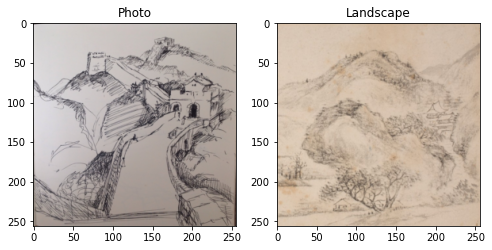

In [248]:
'''
rearranges the original tensor according to the desired ordering 
and returns a new multidimensional rotated tensor
'''
figure = plt.figure(figsize=(8, 8))

figure.add_subplot(1, 2, 1)
plt.title('Photo')
photo_img = unnorm(photo_img)
plt.imshow(photo_img[0].permute(1, 2, 0))

figure.add_subplot(1, 2, 2)
plt.title('Landscape')
landscape_img = unnorm(landscape_img)
plt.imshow(landscape_img[0].permute(1, 2, 0))

In [23]:
def load_checkpoint(path, map_location=None):
    checkpoint = torch.load(path, map_location=map_location)
    print(' [*] Loading checkpoint from %s succeed!' % path)
    return checkpoint
def save_checkpoint(state, save_path):
    torch.save(state, save_path)

## Model - Generator


In [86]:
'''
For generator model, first build the downsample and upsample functions, 
where upsample increase the dimension of the images 
and downsample do the opposite.
'''

def downsample(in_channel, out_channel, apply_dropout=True):
    downsample_model = []
    downsample_model.append(nn.Conv2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1))
    downsample_model.append(nn.InstanceNorm2d(out_channel))
    if apply_dropout:
        downsample_model.append(nn.Dropout(0.5))
    downsample_model.append(nn.ReLU())
    
    return nn.Sequential(*downsample)

def upsample(in_channel, out_channel, apply_dropout=True):
    upsample_model = []
    upsample_model.append(nn.ConvTranspose2d(in_channel, out_channel, 3, stride=2, padding=1, output_padding=1))
    upsample_model.append(nn.InstanceNorm2d(out_channel))
   
    if apply_dropout:
        upsample_model.append(nn.Dropout(0.5))
    upsample_model.append(nn.ReLU())
    
    return nn.Sequential(*upsample_model)


In [126]:
def Conv_2(in_channel, out_channel, kernels=3, stride=2, leaky=True, inst_norm=True, pad=True):
    model = []
    
    if pad:
        model.append(nn.Conv2d(in_channel, out_channel, kernels, stride, 1, bias=True))  
    else:
        model.append(nn.Conv2d(in_channel, out_channel, kernels, stride, 0, bias=True))

    if inst_norm:
        model.append(nn.InstanceNorm2d(out_channel))
    else:
        model.append(nn.BatchNorm2d(out_ch))
        
    if leaky:
        model.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
    else:
        model.append(nn.ReLU())

    return nn.Sequential(*model)

In [134]:
'''
Residual Blocks are skip-connection blocks that learn 
residual functions with reference to the layer inputs, 
instead of learning unreferenced functions.
'''
class ResidualBlock(nn.Module):
    def __init__(self, dim, apply_dropout=True):
        super().__init__()
        self.conv1 = Conv_2(dim, dim, kernels=3, stride=1, leaky=False, inst_norm=True,pad=True)
        self.conv2 = Conv_2(dim,dim, kernels=3, stride=1, leaky=False, inst_norm=True,pad=True)

    def forward(self, x):
        out_1 = F.relu(self.conv1(x))
        out_2 = x + self.conv2(out_1)
        return out_2

In [147]:
'''
Generator Model:
'''
class Generator(nn.Module):
    def __init__(self, in_chanel, out_chanel, num_res_blocks=6):
        super().__init__()
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Conv_2(in_chanel, 64, 7, 1, False, True, False))
        model.append(Conv_2(64, 128, 3, 2, False))
        model.append(Conv_2(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(ResidualBlock(256))
        model.append(upsample(256, 128))
        model.append(upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_chanel, kernel_size=7, padding=0))
        model.append(nn.Tanh())

        self.generate = nn.Sequential(*model)

    def forward(self, x):
        return self.generate(x)

In [150]:
'''
Discriminator Model:
'''
class Discriminator(nn.Module):
    def __init__(self, in_chanel, n=4):
        super().__init__()
        model = list()
        model.append(nn.Conv2d(in_chanel, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, n):
            in_chanel = 64 * 2**(i-1)
            out_chanel = in_chanel * 2
            if i == n -1:
                model.append(Conv_2(in_chanel, out_chanel, 4, 1))
            else:
                model.append(Conv_2(in_chanel, out_chanel, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

## Additional Functions

In [167]:
def weights_init(m):
    """
    Applies initial weights to certain layers in a model.
    The weights are taken from a normal distribution with mean = 0, std dev = 0.02.
    Param m: A module or layer in a network    
    """
    classname = m.__class__.__name__
    
    std = 0.02
    mean = 0.0
    
    if hasattr(m, 'weight') and (classname.find('Conv') != -1):
        init.normal_(m.weight.data, mean, std)

In [152]:
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

In [168]:
'''
Referrencing https://arxiv.org/pdf/1612.07828.pdf
Save 50 generated fake imgs and sample through them
to feed discriminators to avoid large oscillations 
from iterations to iterations.
'''

class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

In [154]:
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract

In [155]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

## CycleGAN

In [268]:
lr=0.0002 
beta1=0.5  #exponential decay rate for the first moment estimates
beta2=0.999 #exponential decay rate for the second-moment estimates

class CycleGAN(object):
    def __init__(self, in_chanel, out_chanel, epochs, device,lr=2e-4, lmbda=10, idt_coef=0.5):
        self.epochs = epochs
        self.decay_epoch = int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen1 = Generator(in_chanel, out_chanel)
        self.gen2 = Generator(in_chanel, out_chanel)
        self.disc1 = Discriminator(in_chanel)
        self.disc2 = Discriminator(in_chanel)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen1.parameters(), self.gen2.parameters()),
                                         lr = lr, betas=(beta1, beta2))
        self.adam_desc = torch.optim.Adam(itertools.chain(self.disc1.parameters(), self.disc2.parameters()),
                                          lr=lr, betas=(beta1, beta2))
        self.sample_l = sample_fake()
        self.sample_p = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.adam_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        weights_init(self.gen1)
        weights_init(self.gen2)
        weights_init(self.disc1)
        weights_init(self.disc2)
        self.gen1 = self.gen1.to(self.device)
        self.gen2 = self.gen2.to(self.device)
        self.disc1 = self.disc1.to(self.device)
        self.disc2 = self.disc2.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (p, l) in enumerate(t):
                photo_img, landscape_img = p.to(device), l.to(device) #load real images
                update_req_grad([self.disc1, self.disc2], False)
                
                # Zero out all of the gradients for the variables which the optimizer
                # will update.
                self.adam_gen.zero_grad()

                # Forward pass through generator
                fake_p = self.gen1(landscape_img)
                fake_l = self.gen2(photo_img)

                cycl_l = self.gen2(fake_p)
                cycl_p = self.gen1(fake_l)

                id_l = self.gen2(landscape_img)
                id_p = self.gen1(photo_img)

                # generator losses - identity, Adversarial, cycle consistency
                idt_loss_l = self.l1_loss(id_l, landscape_img) * self.lmbda * self.idt_coef
                idt_loss_p = self.l1_loss(id_p, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_l = self.l1_loss(cycl_l, landscape_img) * self.lmbda
                cycle_loss_p = self.l1_loss(cycl_p, photo_img) * self.lmbda

                disc_l = self.disc1(fake_l)
                disc_p = self.disc2(fake_p)

                real = torch.ones(disc_l.size()).to(self.device)

                adv_loss_l = self.mse_loss(disc_l, real)
                adv_loss_p = self.mse_loss(disc_p, real)

                # compute total generator loss and average loss
                total_gen_loss = cycle_loss_l + adv_loss_l\
                              + cycle_loss_p + adv_loss_p\
                              + idt_loss_l + idt_loss_p
                
                avg_gen_loss += total_gen_loss.item()


                # This is the backwards pass: compute the gradient of the loss with
                # respect to each  parameter of the model.
                total_gen_loss.backward()
                # Actually update the parameters of the model using the gradients
                # computed by the backwards pass.
                self.adam_gen.step()

                # Forward pass through Descriminator
                update_req_grad([self.disc1, self.disc2], True)
                self.adam_desc.zero_grad()

                fake_l = self.sample_l([fake_l.cpu().data.numpy()])[0]
                fake_p = self.sample_p([fake_p.cpu().data.numpy()])[0]
                fake_l = torch.tensor(fake_l).to(self.device)
                fake_p = torch.tensor(fake_p).to(self.device)

                land_desc_real = self.disc1(landscape_img)
                land_desc_fake = self.disc1(fake_l)
                photo_desc_real = self.disc2(photo_img)
                photo_desc_fake = self.disc2(fake_p)

                real = torch.ones(land_desc_real.size()).to(self.device)
                fake = torch.ones(land_desc_fake.size()).to(self.device)

                # Descriminator losses
                # --------------------
                land_desc_real_loss = self.mse_loss(land_desc_real, real)
                land_desc_fake_loss = self.mse_loss(land_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                land_desc_loss = (land_desc_real_loss + land_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = land_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # Backward
                land_desc_loss.backward()
                photo_desc_loss.backward()
                self.adam_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())

            save_dict = {
                'epoch': epoch+1,
                'gen1': gan.gen1.state_dict(),
                'gen2': gan.gen2.state_dict(),
                'disc1': gan.disc1.state_dict(),
                'disc2': gan.disc2.state_dict(),
                'optimizer_gen': gan.adam_gen.state_dict(),
                'optimizer_desc': gan.adam_desc.state_dict()
            }
            save_checkpoint(save_dict, 'current.ckpt')
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch: (%d) | Generator Loss:%f | Discriminator Loss:%f" % 
                                                (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

In [269]:
gan = CycleGAN(3, 3, 50, device)

In [270]:
#initialize the dictionary before training
save_dict = {
    'epoch': 0,
    'gen1': gan.gen1.state_dict(),
    'gen2': gan.gen2.state_dict(),
    'disc1': gan.disc1.state_dict(),
    'disc2': gan.disc2.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_desc.state_dict()
}

In [271]:
save_checkpoint(save_dict, 'init.ckpt')

In [272]:
gan.train(images_loader)

Epoch: (1) | Generator Loss:12.671601 | Discriminator Loss:0.489765


Epoch: (2) | Generator Loss:9.473253 | Discriminator Loss:0.086927


Epoch: (3) | Generator Loss:9.622008 | Discriminator Loss:0.069962


Epoch: (4) | Generator Loss:9.073048 | Discriminator Loss:0.065155


Epoch: (5) | Generator Loss:9.132036 | Discriminator Loss:0.047124


Epoch: (6) | Generator Loss:8.932348 | Discriminator Loss:0.034518


Epoch: (7) | Generator Loss:8.630652 | Discriminator Loss:0.052978


Epoch: (8) | Generator Loss:9.288828 | Discriminator Loss:0.041386


Epoch: (9) | Generator Loss:8.012963 | Discriminator Loss:0.020924


Epoch: (10) | Generator Loss:9.204213 | Discriminator Loss:0.027818


Epoch: (11) | Generator Loss:8.463085 | Discriminator Loss:0.070632


Epoch: (12) | Generator Loss:8.318821 | Discriminator Loss:0.048496


Epoch: (13) | Generator Loss:8.489338 | Discriminator Loss:0.019553


Epoch: (14) | Generator Loss:8.055968 | Discriminator Loss:0.024018


Epoch: (15) | Generator Loss:8.798827 | Discriminator Loss:0.021292


Epoch: (16) | Generator Loss:7.250982 | Discriminator Loss:0.035445


Epoch: (17) | Generator Loss:7.564433 | Discriminator Loss:0.023345


Epoch: (18) | Generator Loss:8.335462 | Discriminator Loss:0.021855


Epoch: (19) | Generator Loss:8.400612 | Discriminator Loss:0.025292


Epoch: (20) | Generator Loss:7.280313 | Discriminator Loss:0.019400


Epoch: (21) | Generator Loss:8.992924 | Discriminator Loss:0.567058


Epoch: (22) | Generator Loss:8.535841 | Discriminator Loss:0.692919


Epoch: (23) | Generator Loss:8.736994 | Discriminator Loss:0.031736


Epoch: (24) | Generator Loss:8.154704 | Discriminator Loss:0.047754


Epoch: (25) | Generator Loss:7.448912 | Discriminator Loss:0.030022


Epoch: (26) | Generator Loss:7.691810 | Discriminator Loss:0.026547


Epoch: (27) | Generator Loss:7.611626 | Discriminator Loss:0.014890


Epoch: (28) | Generator Loss:7.407830 | Discriminator Loss:0.010761


Epoch: (29) | Generator Loss:7.238887 | Discriminator Loss:0.013670


Epoch: (30) | Generator Loss:6.945383 | Discriminator Loss:0.009499


Epoch: (31) | Generator Loss:6.532380 | Discriminator Loss:0.009742


Epoch: (32) | Generator Loss:7.074600 | Discriminator Loss:0.008651


Epoch: (33) | Generator Loss:6.882932 | Discriminator Loss:0.008067


Epoch: (34) | Generator Loss:7.254899 | Discriminator Loss:0.007385


Epoch: (35) | Generator Loss:6.723339 | Discriminator Loss:0.006900


Epoch: (36) | Generator Loss:7.371783 | Discriminator Loss:0.005608


Epoch: (37) | Generator Loss:6.928499 | Discriminator Loss:0.005073


Epoch: (38) | Generator Loss:6.724684 | Discriminator Loss:0.006164


Epoch: (39) | Generator Loss:6.266811 | Discriminator Loss:0.005537


Epoch: (40) | Generator Loss:6.032047 | Discriminator Loss:0.004688


Epoch: (41) | Generator Loss:6.420585 | Discriminator Loss:0.004009


Epoch: (42) | Generator Loss:7.405096 | Discriminator Loss:0.004611


Epoch: (43) | Generator Loss:5.974431 | Discriminator Loss:0.004398


Epoch: (44) | Generator Loss:5.834009 | Discriminator Loss:0.003182


Epoch: (45) | Generator Loss:5.314986 | Discriminator Loss:0.004198


Epoch: (46) | Generator Loss:6.251972 | Discriminator Loss:0.003573


Epoch: (47) | Generator Loss:5.159968 | Discriminator Loss:0.003297


Epoch: (48) | Generator Loss:5.514877 | Discriminator Loss:0.003156


Epoch: (49) | Generator Loss:5.215341 | Discriminator Loss:0.003642


Epoch: (50) | Generator Loss:5.475309 | Discriminator Loss:0.002887


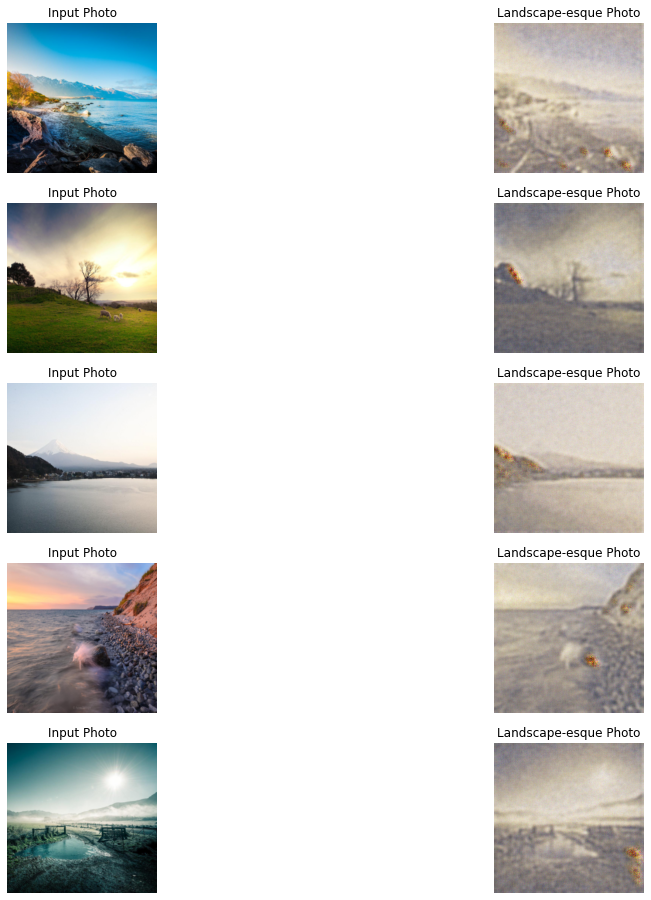

In [273]:
_, ax = plt.subplots(5, 2, figsize=(16, 16))
for i in range(5):
    photo_img, _ = next(iter(images_loader))
    pred_land = gan.gen2(photo_img.to(device)).cpu().detach()
    photo_img = unnorm(photo_img)
    pred_land = unnorm(pred_land)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_land[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Landscape-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()